In [1]:
# Imports
from pyspark.sql import SparkSession 
from pyspark.sql import SQLContext

In [2]:
print(sc)

<SparkContext master=local[*] appName=PySparkShell>


In [3]:
# 1 - Spark Session (to work with spark)
spSession = SparkSession.builder.master("local").appName("SparkSQL").getOrCreate()

In [4]:
# 2 - Initialize SQLContext (to work with Spark SQL) 
sqlContext = SQLContext(sc)

In [5]:
# To grab a PARQUET file and create a dataframe out of it
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2021-02-23 13:01:31--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2021-02-23 13:01:31--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2021-02-23 13:01:32--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [6]:
# Dataframe to a temp view
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [7]:
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
df.count()

2058

# BoxPlot

In [9]:
# Using Spark SQL, we issue a SQL query to get a voltage values
result_volt = spark.sql('select voltage from washing where voltage is not null')
result_volt.collect()

[Row(voltage=236),
 Row(voltage=235),
 Row(voltage=228),
 Row(voltage=236),
 Row(voltage=233),
 Row(voltage=226),
 Row(voltage=235),
 Row(voltage=220),
 Row(voltage=225),
 Row(voltage=239),
 Row(voltage=230),
 Row(voltage=236),
 Row(voltage=244),
 Row(voltage=235),
 Row(voltage=234),
 Row(voltage=224),
 Row(voltage=225),
 Row(voltage=223),
 Row(voltage=236),
 Row(voltage=226),
 Row(voltage=227),
 Row(voltage=237),
 Row(voltage=233),
 Row(voltage=226),
 Row(voltage=222),
 Row(voltage=228),
 Row(voltage=227),
 Row(voltage=228),
 Row(voltage=232),
 Row(voltage=225),
 Row(voltage=229),
 Row(voltage=224),
 Row(voltage=235),
 Row(voltage=233),
 Row(voltage=226),
 Row(voltage=239),
 Row(voltage=238),
 Row(voltage=222),
 Row(voltage=226),
 Row(voltage=236),
 Row(voltage=230),
 Row(voltage=235),
 Row(voltage=237),
 Row(voltage=225),
 Row(voltage=228),
 Row(voltage=221),
 Row(voltage=232),
 Row(voltage=221),
 Row(voltage=230),
 Row(voltage=231),
 Row(voltage=220),
 Row(voltage=235),
 Row(voltage

### NOTE: 
seems that the values are somehow wrapped in a row object (agrupados em um obj de linha), we use the Lambda function to obtain individual instances of the row wrappers objects, and in the lambda function, we basically can directly access the wrapped value. 


In [10]:
# Dataframes are wrappers of rdds, we can access the wrapped rdd and the rdd API in order to extract the 
# containing values in the row wrapper objects.
result_volt.rdd.map(lambda row : row.voltage).take(10)

[236, 235, 228, 236, 233, 226, 235, 220, 225, 239]

### **Important:
The most important function this week is the sample function, in order to obtain a random fraction of the original data, this is not necessary here. But imagine that this dataframe could potentially contain trillions of rows on petabytes of data!!!   

In [11]:
result_volt_array = result_volt.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()
result_volt_array

[236,
 227,
 225,
 233,
 230,
 222,
 235,
 237,
 231,
 234,
 238,
 231,
 233,
 248,
 220,
 225,
 247,
 236,
 254,
 224,
 231,
 220,
 234,
 228,
 238,
 234,
 233,
 235,
 229,
 235,
 223,
 234,
 236,
 232,
 223,
 226,
 231,
 231,
 233,
 224,
 230,
 235,
 234,
 221,
 232,
 220,
 237]

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

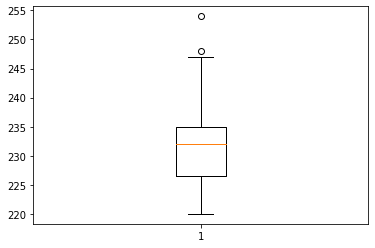

In [13]:
# Plot
plt.boxplot(result_volt_array)
plt.show()

# Run charts

In [14]:
# For creating a run chart, we need to fetch an additional dimension from our dataset namely the time dimension
result = spark.sql('select voltage,ts from washing where voltage is not null order by ts asc')
result_array = result.rdd.sample(False,0.1).map(lambda row : (row.ts, row.voltage)).collect()
result_array

[(1547808734922, 234),
 (1547808779950, 220),
 (1547808782951, 220),
 (1547808906089, 228),
 (1547808918094, 222),
 (1547808936120, 234),
 (1547808966142, 221),
 (1547808969144, 231),
 (1547809014196, 255),
 (1547809191320, 238),
 (1547809200323, 234),
 (1547809233344, 236),
 (1547809257358, 225),
 (1547809269373, 235),
 (1547809284381, 228),
 (1547809383432, 239),
 (1547809431468, 227),
 (1547809452479, 236),
 (1547809455481, 231),
 (1547809458483, 234),
 (1547809476494, 223),
 (1547809527533, 229),
 (1547809563554, 239),
 (1547809602581, 251),
 (1547809608585, 253),
 (1547809611586, 250),
 (1547809695646, 229),
 (1547809761693, 235),
 (1547809776704, 223),
 (1547809794715, 221),
 (1547809827733, 231),
 (1547809830733, 223),
 (1547809836736, 221),
 (1547809839737, 232),
 (1547809869750, 232),
 (1547809917777, 254),
 (1547809935784, 220),
 (1547809938785, 236),
 (1547809944788, 228),
 (1547810043826, 233),
 (1547810046827, 236)]

In [15]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808722910, 1547808737926, 1547808764937, 1547808794957, 1547808852031, 1547808858035, 1547808876043, 1547808885074, 1547808918094, 1547808945126, 1547808999173, 1547809026203, 1547809122262, 1547809125263, 1547809170308]
[221, 234, 221, 224, 223, 228, 221, 226, 222, 230, 247, 221, 235, 237, 226]


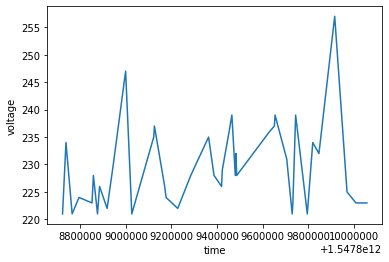

In [17]:
# Plot timestamp
plt.plot(result_array_ts, result_array_voltage)
plt.xlabel('time')
plt.ylabel('voltage')
plt.show()

# ScatterPlots

In [20]:
# Let's add the columns to the projection list, we have to exclude the null values
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
# Unwrap the row objects
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))

result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()

result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()

result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

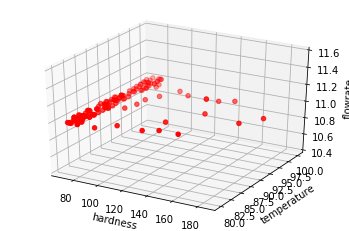

In [22]:
# Once done it is very simple to import the necessary library and create a scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

# Histograms

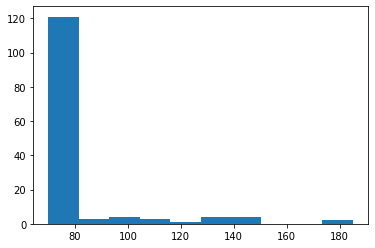

In [23]:
plt.hist(result_array_hardness)
plt.show()

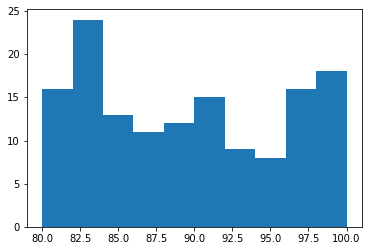

In [24]:
plt.hist(result_array_temperature)
plt.show()

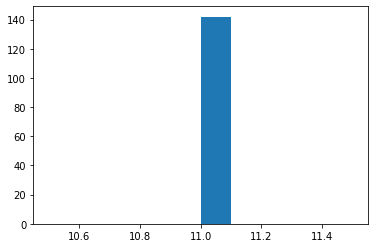

In [25]:
plt.hist(result_array_flowrate)
plt.show()

# End